In [ ]:
!pip install --upgrade pip
!pip install numpy pandas scikit-learn matplotlib openpyxl


In [ ]:
import re, numpy as np, pandas as pd
from pathlib import Path

FILE = "41467_2024_54434_MOESM11_ESM.xlsx"  
SHEET = 0
IDCOL = "Gene_ID"

df = pd.read_excel(FILE, sheet_name=SHEET)
print(df.shape)
df.head(3)


(60668, 291)


,Gene_ID,RE-P002-T,RE-P003-N,RE-P003-T,RE-P005-T,RE-P007-N,RE-P007-T,RE-P009-N,RE-P009-T,RE-P011-N,...,RE-P222-T,RE-P223-T,RE-P224-T,RE-P225-T,RE-P226-T,RE-P227-T,RE-P228-T,RE-P229-T,RE-P230-T,RE-P231-T
0,ENSG00000000003.15,3.386150,2.783910,1.25578,0.377956,0.96720,1.03291,0.09904,0.381092,0.35519,...,7.684670,9.8253,16.158700,19.8716,3.520290,15.723100,14.457700,11.361100,4.52266,13.0769
1,ENSG00000000005.6,0.066265,0.207569,0.02075,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.063195,0.0000,0.033908,0.0000,0.130374,0.369316,0.034893,0.110145,0.00000,0.0000
2,ENSG00000000419.12,3.464430,4.255150,2.81041,1.378370,2.70145,5.03921,1.66132,2.595090,1.08718,...,13.746500,38.4231,26.149500,18.1865,12.234500,59.131500,28.186600,25.400000,24.09840,20.0083


In [ ]:
# =========================================================
#   샘플 메타 정보 파싱 (Normal/Tumor pair 구조 추출)
# =========================================================

# IDCOL 제외한 모든 sample column 이름을 수집
sample_cols = [c for c in df.columns if c != IDCOL]

meta = []
for c in sample_cols:
    # 샘플명 규칙:  "<PAIR_ID>-N" 또는 "<PAIR_ID>-T"
    # 예) "TCGA-AB-1234-N", "TCGA-AB-1234-T"
    if c.endswith("-N"):
        meta.append({"sample": c, "pair_id": c[:-2], "cond": "N"})
    elif c.endswith("-T"):
        meta.append({"sample": c, "pair_id": c[:-2], "cond": "T"})

# 메타 테이블 생성
meta = pd.DataFrame(meta)

# =========================================================
#   Normal과 Tumor가 모두 존재하는 pair만 유지
#   (paired tumor-normal 분석의 핵심 단계)
# =========================================================

# pair_id 기준 cond 값(N/T)의 종류가 2개(N,T)인 경우만 True
pairs = (meta.groupby("pair_id")["cond"].nunique() == 2)

# paired N/T가 모두 있는 pair_id 목록
has_both = pairs[pairs].index

# 필터링 적용
meta_pair = meta[meta["pair_id"].isin(has_both)].copy()


# =========================================================
#   하나의 pair 당 Normal 1개 / Tumor 1개만 선택
#   (중복 샘플 있으면 첫 번째만 사용)
# =========================================================
normal_cols, tumor_cols, pair_ids = [], [], []

for pid, g in meta_pair.groupby("pair_id"):
    n = g[g["cond"] == "N"]["sample"].tolist()  # Normal 샘플들
    t = g[g["cond"] == "T"]["sample"].tolist()  # Tumor 샘플들
    if len(n) == 0 or len(t) == 0:
        continue

    # 같은 PID에서 중복 Normal/Tumor 존재할 수 있음 → 첫 번째만 사용
    normal_cols.append(n[0])
    tumor_cols.append(t[0])
    pair_ids.append(pid)


# =========================================================
#   유전자 x 샘플 매트릭스 구성
# =========================================================

# gene ID 가져오기
genes = df[IDCOL].astype(str).values

# df에서 gene row 기준으로 sample column만 남김
# X의 shape = (genes, samples)
X = df.set_index(IDCOL)[normal_cols + tumor_cols].astype(float)

# Normal/Tumor 행렬 분리
#   - (pairs × genes) 형태 되도록 전치(T)
Xn = X[normal_cols].T.values   # Normal
Xt = X[tumor_cols].T.values    # Tumor

# 출력: pair 수, Normal matrix shape, Tumor matrix shape
len(pair_ids), Xn.shape, Xt.shape


(85, (85, 60668), (85, 60668))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# RNA-seq 데이터에서 변동이 높은 유전자만 선택 (5k~12k 적절)
TOP_VAR_GENES = 8000
USE_PCA = True
PCA_DIM  = 128
SEED = 42
np.random.seed(SEED)

def to_num(A):
    """
    DataFrame/array를 float 숫자형으로 강제 변환.
    - parsing 실패 시 NaN 부여
    - 이후 NaN은 후속 처리에서 정제
    """
    A = pd.DataFrame(A).apply(pd.to_numeric, errors='coerce').values
    A[~np.isfinite(A)] = np.nan
    return A

def log1p(A):
    """ log1p 변환 (log(1+x)) → RNA count 안정화에 매우 흔히 사용됨 """
    return np.log1p(A)


# =========================================================
#   1) 안전한 수치 변환 + log1p 변환
# =========================================================
Xn = to_num(Xn)    # Normal
Xt = to_num(Xt)    # Tumor
Xn = log1p(Xn)
Xt = log1p(Xt)

# =========================================================
#   2) 모든 샘플에서 해당 유전자가 전부 NaN이면 완전 제거
# =========================================================
all_log = np.vstack([Xn, Xt])
keep = ~np.all(~np.isfinite(all_log), axis=0)  # True = 의미 있는 gene
Xn = np.nan_to_num(Xn[:, keep], nan=0.0)
Xt = np.nan_to_num(Xt[:, keep], nan=0.0)
genes_sel = genes[keep]  # gene 이름도 동일하게 필터링


# =========================================================
#   3) 분산 0 유전자 제거 + 상위 변동 유전자의 subset 선택
# =========================================================
var = np.vstack([Xn, Xt]).var(axis=0)  # 전체에서의 feature-wise 분산
mask = var > 0                         # 분산 0인 gene 제거
Xn = Xn[:, mask]
Xt = Xt[:, mask]
genes_sel = genes_sel[mask]

topk = min(TOP_VAR_GENES, Xn.shape[1])
# 분산 기준 상위 유전자 고름 (역정렬)
idx = np.argsort(var[mask])[::-1][:topk]
Xn = Xn[:, idx]
Xt = Xt[:, idx]
genes_sel = genes_sel[idx]


# =========================================================
#   4) StandardScaler로 모든 샘플/유전자 스케일링 (mean=0, std=1)
#      - Normal/Tumor 합본에 대해 fit → batch 간 scale alignment
# =========================================================
scaler = StandardScaler()
X_all = np.vstack([Xn, Xt])      # 합본
X_all = scaler.fit_transform(X_all)

nN = Xn.shape[0]
Xn_z = X_all[:nN]                # 스케일된 Normal
Xt_z = X_all[nN:]                # 스케일된 Tumor


# =========================================================
#   5) PCA 축소 (합본으로 fit → Normal/Tumor 동일한 projection 사용)
#      - PCA는 batch-level 및 feature-level 잡음 제거 효과
#      - component 수는 (PCA_DIM, feature수, sample수-1) 중 최소
# =========================================================
if USE_PCA:
    pca = PCA(
        n_components=min(PCA_DIM, Xn_z.shape[1], X_all.shape[0] - 1),
        random_state=SEED
    )
    X_all_m = pca.fit_transform(X_all)
    Xn_m = X_all_m[:nN]
    Xt_m = X_all_m[nN:]
else:
    pca = None
    Xn_m, Xt_m = Xn_z, Xt_z

# 출력: PCA 또는 StandardScaler 후의 latent/model space shape
Xn_m.shape, Xt_m.shape


((85, 128), (85, 128))

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

def fit_bgm(X, seed=42):
    """
    Bayesian Gaussian Mixture Model(BGM)을 데이터 X에 fit하는 함수.

    BGM은 일반 GMM과 달리:
      - Dirichlet Process Prior 사용 → 필요 없는 성분(component)의 weight가 자연스럽게 0 근처로 수렴
      - component 수가 '최대치'로 주어져도 실제로는 fewer components가 active하게 됨
      - 소규모 데이터에 대해 과적합이 덜 발생하는 장점

    Parameters
    ----------
    X : ndarray (n_samples, n_features)
        모델 공간(latent PCA/BATCH space)의 데이터
    seed : int
        초기화 및 난수 제어

    Returns
    -------
    bgm : BayesianGaussianMixture
        학습된 mixture model
    """

    # -------------------------------------------
    #  구성요소 최대 개수 자동 설정
    # -------------------------------------------
    # 경험적 가이드:
    #   - 최소 3개
    #   - 최대 12개
    #   - 표본이 충분하면 n/8 정도를 상한으로 사용
    n = X.shape[0]
    n_comp = max(3, min(12, n//8 if n >= 24 else 3))

    # -------------------------------------------
    #  BGM 설정
    # -------------------------------------------
    bgm = BayesianGaussianMixture(
        n_components=n_comp,                 # 최대 component 수
        covariance_type="full",              # full covariance Σ_k
        weight_concentration_prior_type="dirichlet_process",
        # concentration < 1 → sparsity 유도 (불필요한 component weight shrinking)
        weight_concentration_prior=0.5,
        reg_covar=1e-6,                      # 수치적 안정성 위한 Σ regularization
        init_params="kmeans",                # 초기화 방식
        max_iter=1000,                       # EM 반복 최대치
        random_state=seed
    )

    # mixture 모델 학습
    bgm.fit(X)
    return bgm


# =========================================================
# Normal / Tumor 데이터 각각에 대해 mixture fitting
# =========================================================
bgm_N = fit_bgm(Xn_m, seed=SEED)
bgm_T = fit_bgm(Xt_m, seed=SEED)

# 활성 성분 수 확인 (weight > 0.01 인 component만 계산)
print("N comps(weights>0.01):", np.sum(bgm_N.weights_ > 0.01))
print("T comps(weights>0.01):", np.sum(bgm_T.weights_ > 0.01))


N comps(weights>0.01): 9
T comps(weights>0.01): 10


In [ ]:
N_SYN = 500  # 클래스별 합성 샘플 수

def sample_bgm(model, n):
    """
    Gaussian Mixture Model(BGM)에서 n개의 샘플을 생성하는 함수.
    model.sample(n)은 (samples, component_indices)를 반환하므로
    samples만 반환하도록 구성.
    """
    return model.sample(n)[0]

# =========================================================
#   BGM으로부터 Normal/Tumor 합성 샘플 생성 (latent/model 공간)
# =========================================================
synN = sample_bgm(bgm_N, N_SYN)   # Normal mixture에서 샘플링
synT = sample_bgm(bgm_T, N_SYN)   # Tumor mixture에서 샘플링

# ---------------------------------------------------------
#  합성 샘플에 약간의 가우시안 노이즈 추가 (mode collapse 방지)
#  - 너무 딱 mixture의 중심에 붙어 clustering되는 것을 완화
#  - 노이즈 크기(0.01~0.04)는 일반적으로 가장 안정적인 범위
# ---------------------------------------------------------
noise = 0.02
synN += noise * np.random.randn(*synN.shape)
synT += noise * np.random.randn(*synT.shape)


# =========================================================
#   1차/2차 모멘트 매칭 (Mean/Std per feature correction)
# =========================================================
def match_moments(X_src, X_ref):
    """
    소스 분포 X_src의 각 feature별 평균/표준편차를
    레퍼런스 분포 X_ref의 통계에 맞추는 정규화 매핑.

    X_src': = (X_src - μ_src) / σ_src * σ_ref + μ_ref

    목적:
      - 합성 데이터의 1~2차 통계가 실제(real) 데이터와 비슷해지도록 조정
      - 특히 mixture sampling만으로는 feature-wise scaling이 달라지는 문제를 보정
    """
    s_mu, s_sd = X_src.mean(0, keepdims=True), X_src.std(0, keepdims=True) + 1e-8
    r_mu, r_sd = X_ref.mean(0, keepdims=True), X_ref.std(0, keepdims=True) + 1e-8
    return (X_src - s_mu) / s_sd * r_sd + r_mu


# Normal/Tumor 각각 실제 데이터(Xn_m, Xt_m)를 참조하여 보정
synN = match_moments(synN, Xn_m)
synT = match_moments(synT, Xt_m)


# =========================================================
#   latent/model 공간 → gene expression 원공간으로 역변환
# =========================================================
def inverse_to_gene(Xm):
    """
    모델 공간(latent) 데이터 Xm을 원래 gene expression 스케일로 되돌리는 함수.

    처리 순서:
      1) PCA가 존재하면 역변환 (latent → batch-scaled gene space)
      2) scaler.inverse_transform으로 정규화 해제
      3) expm1 적용: log1p로 변환했던 RNA count를 원래 count로 복원
    """
    Xb = Xm
    if pca is not None:
        Xb = pca.inverse_transform(Xb)
    Xb = scaler.inverse_transform(Xb)
    return np.expm1(Xb)  # log1p → 원래 count 단위로 복원


# gene space 합성 데이터 생성
synN_gene = inverse_to_gene(synN)
synT_gene = inverse_to_gene(synT)

# 출력: latent space와 gene space의 shape
synN.shape, synT.shape, synN_gene.shape


((500, 128), (500, 128), (500, 8000))

In [ ]:
# Cell 6b: Mixture-wise affine alignment (component-level mean/cov matching)
import numpy as np

def psd_sqrt(mat):
    """
    대칭 양의 준정정부호(PSD) 행렬의 matrix square root(Σ^(1/2))를 계산.
    SVD 기반으로 구현하여 수치안정성 확보.

    mat ≈ U diag(S) U^T  (S: 고유값)
    → mat^(1/2) = U diag(sqrt(S)) U^T
    """
    # 수치적 안정성을 위해 (mat + mat.T)/2 로 대칭화
    U, S, Vt = np.linalg.svd((mat + mat.T) / 2.0, full_matrices=False)
    # clip(S)로 음수/0 근처 고유값 제거 → sqrt 안정화
    return (U * np.sqrt(np.clip(S, 1e-10, None))) @ Vt


def psd_invsqrt(mat):
    """
    PSD 행렬의 inverse square root(Σ^(-1/2)) 계산.

    mat ≈ U diag(S) U^T
    → mat^(-1/2) = U diag(1/sqrt(S)) U^T
    """
    U, S, Vt = np.linalg.svd((mat + mat.T) / 2.0, full_matrices=False)
    return (U * (1.0 / np.sqrt(np.clip(S, 1e-10, None)))) @ Vt


def align_by_component(syn, bgm_syn, real_data, bgm_real, soften=0.05):
    """
    === Mixture-wise Affine Alignment ===
    합성 데이터(syn)의 Gaussian mixture component별 평균/공분산을
    실제 데이터(real_data)의 대응 component의 통계(μ, Σ)에 맞추어
    선형변환(affine transform)으로 보정하는 단계.

    (의미)
    SYN 분포의 k번 성분 ~ N(μ_s, Σ_s)
    REAL 분포의 k번 성분 ~ N(μ_r, Σ_r)

    목표: SYN 샘플 x 를 REAL 성분의 통계에 맞추기 위해
          x' = Σ_r^(1/2) Σ_s^(-1/2) (x - μ_s) + μ_r
          형태로 변환해 분포의 shape-align 수행.

    Parameters
    ----------
    syn : ndarray (n_s, d)
        합성 데이터(모델 latent space 기준)
    bgm_syn : mixture model
        합성 데이터에 fit된 Gaussian Mixture (없을 시 bgm_real 사용)
    real_data : ndarray (n_r, d)
        실제 데이터(동일한 latent space)
    bgm_real : mixture model
        실제 데이터에 fit된 Gaussian Mixture
    soften : float
        공분산 행렬에 εI 를 더해 역행렬/루트 계산 시 발산 방지

    Returns
    -------
    out : ndarray (n_s, d)
        성분 단위로 평균/공분산 정렬이 적용된 합성 데이터
    """
    # 합성용 mixture 모델이 없으면 실제 mixture 모델로 대체
    if bgm_syn is None:
        bgm_syn = bgm_real

    # syn 샘플을 실제 mixture 의 어떤 component가 가장 높은 posterior인지 할당
    comp_r = bgm_real.predict(syn)
    comp_s = bgm_syn.predict(syn)

    out = syn.copy()

    for k in np.unique(comp_r):
        # 실제 mixture 기준 component k 에 맵핑된 syn 샘플 index
        idx = np.where(comp_r == k)[0]
        if len(idx) == 0:
            continue

        # Real 쪽 성분 k 의 평균/공분산
        mu_r = bgm_real.means_[k]
        cov_r = bgm_real.covariances_[k] + soften * np.eye(syn.shape[1])

        # Synth 쪽에서 같은 k 와 매칭되지 않을 가능성 → comp_s의 최빈값으로 synth-component 결정
        ks, cnt = np.unique(comp_s[idx], return_counts=True)
        k_s = ks[np.argmax(cnt)]

        # Synth 성분의 평균/공분산
        mu_s = bgm_syn.means_[k_s]
        cov_s = bgm_syn.covariances_[k_s] + soften * np.eye(syn.shape[1])

        # ===== 핵심 선형변환 A = Σ_r^(1/2) Σ_s^(-1/2) =====
        A = psd_sqrt(cov_r) @ psd_invsqrt(cov_s)

        # 합성 데이터 정렬 (x' = A (x - μ_s) + μ_r)
        x = syn[idx] - mu_s
        out[idx] = (x @ A.T) + mu_r

    return out


# ================================================
#   Normal / Tumor 합성 데이터에 대해 component alignment 수행
# ================================================
synN_aligned = align_by_component(synN, bgm_N, Xn_m, bgm_N, soften=0.02)
synT_aligned = align_by_component(synT, bgm_T, Xt_m, bgm_T, soften=0.02)

# 미세한 Gaussian noise 추가하여 mode collapse/경직 방지
synN_aligned += 0.01 * np.random.randn(*synN_aligned.shape)
synT_aligned += 0.01 * np.random.randn(*synT_aligned.shape)

# latent space → 실제 gene expression 공간으로 역변환
synN_gene = inverse_to_gene(synN_aligned)
synT_gene = inverse_to_gene(synT_aligned)


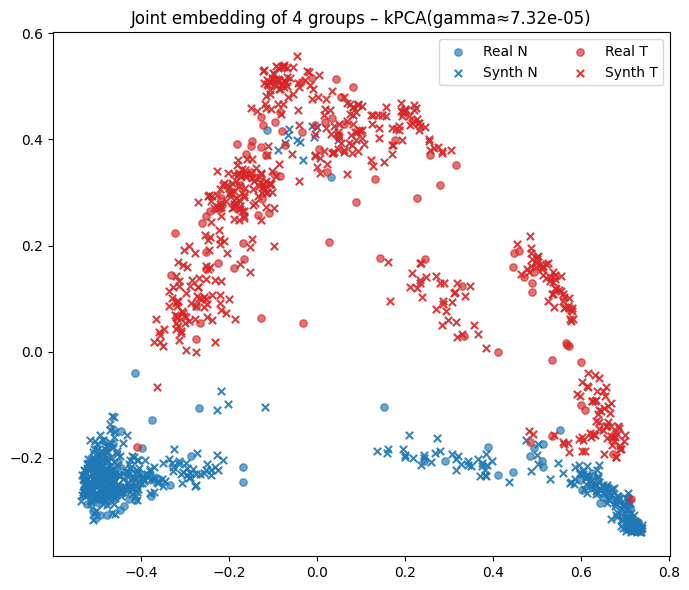

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA, PCA
import numpy as np

# RN: Real Normal
# RT: Real Tumor
# SN: Synth Normal
# ST: Synth Tumor
# 실제 분석에서 사용되는 네 개의 데이터 그룹을 변수에 매핑
RN, RT, SN, ST = Xn_m, Xt_m, synN, synT


def auto_gamma(X):
    """
    RBF 커널의 gamma 값을 데이터 분포로부터 자동 추정하는 함수.
    'median heuristic' 기반으로 샘플의 pairwise 거리의 중앙값을 이용함.

    Parameters
    ----------
    X : ndarray (N, D)
        전체 데이터 행렬

    Returns
    -------
    gamma : float
        RBF 커널의 스케일 파라미터 (1 / median(distance^2))
    """
    # 데이터가 2개 미만이면 거리 계산 불가 → 작은 기본 gamma 사용
    if X.shape[0] < 2:
        return 1e-3

    # 계산 효율을 위해 최대 300개까지만 랜덤 샘플링
    idx = np.random.choice(X.shape[0], size=min(300, X.shape[0]), replace=False)
    Xs  = X[idx]

    # 모든 pairwise L2 distance^2 계산
    d2 = np.sum((Xs[:, None, :] - Xs[None, :, :])**2, axis=2)

    # 자기 자신 제외한 상삼각 행렬 값만 취함
    d2 = d2[np.triu_indices_from(d2, 1)]
    # 0 및 비유효값 제거
    d2 = d2[(d2 > 0) & np.isfinite(d2)]

    # median heuristic 적용
    return 1.0 / (np.median(d2) + 1e-8) if d2.size else 1e-3


# ================================================
#  전체 데이터를 하나로 합쳐 KPCA 또는 PCA로 2D embedding
# ================================================
X_all = np.vstack([RN, RT, SN, ST])

try:
    # 전체 분포 기반 gamma 추정
    g = auto_gamma(X_all)

    # KernelPCA(RBF kernel) 적용 — 비선형 구조까지 반영 가능한 embedding
    kp = KernelPCA(n_components=2, kernel='rbf', gamma=g)
    Z = kp.fit_transform(X_all)
    method = f"kPCA(gamma≈{g:.2e})"

except Exception as e:
    # 만약 KernelPCA에서 numerical issue 발생 → PCA로 fallback
    p = PCA(n_components=2, random_state=SEED)
    Z = p.fit_transform(X_all)
    method = "PCA(fallback)"


# ================================================
#    KPCA/PCA 임베딩 결과를 네 그룹으로 다시 분리
# ================================================
nRN, nRT, nSN, nST = len(RN), len(RT), len(SN), len(ST)

i = 0
Z_RN = Z[i:i+nRN]; i += nRN
Z_RT = Z[i:i+nRT]; i += nRT
Z_SN = Z[i:i+nSN]; i += nSN
Z_ST = Z[i:i+nST]


# ================================================
#                  2D 시각화
# ================================================
plt.figure(figsize=(7, 6))

# Real Normal (파란 원)
plt.scatter(Z_RN[:,0], Z_RN[:,1],
            s=28, c="#1f77b4", marker="o", alpha=0.65, label="Real N")

# Synth Normal (파란 X)
plt.scatter(Z_SN[:,0], Z_SN[:,1],
            s=28, c="#1f77b4", marker="x", alpha=0.9,  label="Synth N")

# Real Tumor (빨간 원)
plt.scatter(Z_RT[:,0], Z_RT[:,1],
            s=28, c="#d62728", marker="o", alpha=0.65, label="Real T")

# Synth Tumor (빨간 X)
plt.scatter(Z_ST[:,0], Z_ST[:,1],
            s=28, c="#d62728", marker="x", alpha=0.9,  label="Synth T")

plt.title(f"Joint embedding of 4 groups – {method}")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

def mmd_rbf(X, Y, gamma=None):
    """
    두 분포 X, Y 사이의 Maximum Mean Discrepancy(MMD)를
    RBF 커널을 이용해 계산하는 함수.

    Parameters
    ----------
    X : ndarray (n_samples_x, n_features)
        첫 번째 샘플 집합 (예: Real Normal)
    Y : ndarray (n_samples_y, n_features)
        두 번째 샘플 집합 (예: Synth Normal)
    gamma : float or None
        RBF 커널의 gamma(=1/(2σ^2)). None이면 데이터 거리의 중앙값으로 자동 추정.

    Returns
    -------
    mmd2 : float
        커널 기반 MMD^2 (항상 0 이상의 값)
    gamma : float
        사용된 RBF gamma 값
    """
    # X, Y 전체 데이터를 하나로 합침 (gamma 자동추정을 위해)
    Z = np.vstack([X, Y])

    # γ 자동 추정 (median heuristic)
    # 모든 쌍 간 거리 제곱(d^2)을 계산 → 그중 상삼각 행렬 요소만 이용
    if gamma is None:
        d2 = np.sum((Z[:, None, :] - Z[None, :, :])**2, axis=2)
        d2 = d2[np.triu_indices_from(d2, 1)]  # 자기 자신 제외
        d2 = d2[(d2 > 0) & np.isfinite(d2)]   # 0 또는 무한/NaN 제거

        # median heuristic: γ = 1 / median(d^2)
        gamma = 1.0 / (np.median(d2) + 1e-8) if d2.size else 1e-3

    # RBF kernel 계산 (Kxx, Kyy: 자기 집합 vs 자기 집합 / Kxy: 교차)
    Kxx = rbf_kernel(X, X, gamma=gamma)
    np.fill_diagonal(Kxx, 0)  # unbiased 추정을 위해 diagonal 제거

    Kyy = rbf_kernel(Y, Y, gamma=gamma)
    np.fill_diagonal(Kyy, 0)

    Kxy = rbf_kernel(X, Y, gamma=gamma)

    n, m = len(X), len(Y)

    # Unbiased MMD^2 estimator
    mmd2 = (
        Kxx.sum() / (n * (n - 1)) +
        Kyy.sum() / (m * (m - 1)) -
        2 * Kxy.mean()
    )

    # MMD^2는 음수가 나올 수 있어도 이론적으로 0 이상 → clip
    return float(max(mmd2, 0)), gamma


# Normal(N)과 Tumor(T)의 현실(real) vs 합성(synth) MMD 계산
mmdN, gN = mmd_rbf(RN, SN)
mmdT, gT = mmd_rbf(RT, ST)

print(f"MMD^2 RealN↔SynthN: {mmdN:.4g}  (γ≈{gN:.2e})")
print(f"MMD^2 RealT↔SynthT: {mmdT:.4g}  (γ≈{gT:.2e})")


def eval_cross(Xtr, ytr, Xte, yte, name):
    """
    Logistic Regression 기반의 이진 분류 모델 평가 함수.

    StandardScaler로 표준화 → LogisticRegression 학습 → AUC/F1/ACC 계산.

    Parameters
    ----------
    Xtr, ytr : training data & label
    Xte, yte : test data & label
    name : str
        결과 print 시 prefix로 사용됨.
    """
    # 파이프라인: StandardScaler → Logistic Regression
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
    clf.fit(Xtr, ytr)

    # 테스트 데이터 확률 예측 (1 클래스 확률)
    prob = clf.predict_proba(Xte)[:, 1]
    pred = (prob >= 0.5).astype(int)

    # AUC/F1/ACC 계산
    auc = roc_auc_score(yte, prob)
    f1 = f1_score(yte, pred)
    acc = accuracy_score(yte, pred)

    print(f"{name}: AUC={auc:.3f}  F1={f1:.3f}  ACC={acc:.3f}")


# ==========================
#        일반화 실험
# ==========================

# Real 데이터만 이용해 N(0) vs T(1) 분류 (train=test, 과적합 여부 확인)
X_real = np.vstack([RN, RT])
y_real = np.array([0] * len(RN) + [1] * len(RT))
eval_cross(X_real, y_real, X_real, y_real, "N↔T on Real (train=test)")

# Synth 데이터만 이용
X_syn = np.vstack([SN, ST])
y_syn = np.array([0] * len(SN) + [1] * len(ST))
eval_cross(X_syn, y_syn, X_syn, y_syn, "N↔T on Synth (train=test)")

# Real → Synth 일반화 성능 (synth 데이터가 real distribution을 얼마나 잘 모방했는지)
eval_cross(X_real, y_real, X_syn, y_syn, "Train Real → Test Synth")

# Synth → Real 일반화 성능 (합성 데이터가 훈련에 쓸 수 있을 정도로 'real-like' 한지)
eval_cross(X_syn, y_syn, X_real, y_real, "Train Synth → Test Real")


MMD^2 RealN↔SynthN: 0  (γ≈1.54e-04)
MMD^2 RealT↔SynthT: 0  (γ≈8.50e-05)
N↔T on Real (train=test): AUC=1.000  F1=1.000  ACC=1.000
N↔T on Synth (train=test): AUC=1.000  F1=1.000  ACC=1.000
Train Real → Test Synth: AUC=1.000  F1=1.000  ACC=1.000
Train Synth → Test Real: AUC=1.000  F1=0.994  ACC=0.994


In [ ]:
import pandas as pd
import numpy as np

# 1) PCA → 표준화 → expm1 순으로 역변환
def inverse_to_original(X_model):
    """
    모델 공간(latent / PCA 공간)의 데이터를
    원본 RNA-seq 스케일(≈ raw count 수준)에 가깝게 되돌리는 함수.

    적용 순서:
      1) PCA 역변환 (latent → scaled gene space)
      2) StandardScaler 역변환 (표준화 해제, 원래 log1p gene space)
      3) expm1 (log1p의 역함수, log1p(count) → count)
      4) NaN/음수 방지 처리를 통해 down-stream 사용 가능 상태로 정제
    """
    X_back = X_model

    # (1) PCA를 사용한 경우에만 역변환 수행
    #     - PCA: X_all_z → X_all_m 로 갔던 것을 다시 되돌리는 단계
    if pca is not None:  # PCA를 사용했으면
        X_back = pca.inverse_transform(X_back)

    # (2) StandardScaler 역변환
    #     - 표준화된 값(평균 0, 분산 1)을 원래 log1p 스케일로 복원
    X_back = scaler.inverse_transform(X_back)

    # (3) log1p의 역함수 expm1 적용
    #     - log1p(count) → count 스케일
    X_back = np.expm1(X_back)

    # (4) NaN 및 음수 값 처리
    #     - NaN → 0으로 치환
    #     - 음수 값은 모두 0으로 클리핑 (RNA count는 음수가 될 수 없음)
    X_back = np.nan_to_num(X_back, nan=0.0)
    X_back = np.clip(X_back, 0, None)

    return X_back


# 2) 합성 Normal/Tumor를 gene expression 전체 스케일로 복원
#    - synN, synT : 모델(PCA/표준화) 공간의 합성 샘플
#    - synN_gene_full, synT_gene_full : 원본 gene space(count) 근사
synN_gene_full = inverse_to_original(synN)
synT_gene_full = inverse_to_original(synT)


# 3) DataFrame 변환 (유전자가 행, 샘플이 열)
#    - 기존 원본 데이터 포맷을 최대한 유지하기 위해
#      gene별 row, sample별 column 구조로 만듦
df_synN = pd.DataFrame(
    synN_gene_full.T,  # (samples, genes) → (genes, samples)로 전치
    index=genes_sel,   # 행 index: 선택된 유전자 ID
    columns=[f"SYN_N_{i+1:03d}" for i in range(synN_gene_full.shape[0])]  # 샘플 이름
)

df_synT = pd.DataFrame(
    synT_gene_full.T,
    index=genes_sel,
    columns=[f"SYN_T_{i+1:03d}" for i in range(synT_gene_full.shape[0])]
)


# 4) Gene_ID를 첫 열로 이동 (원본 파일처럼 Gene_ID 컬럼을 앞에 두기)
df_synN.reset_index(inplace=True)            # index → "index" 컬럼으로 이동
df_synN.rename(columns={"index": "Gene_ID"}, inplace=True)

df_synT.reset_index(inplace=True)
df_synT.rename(columns={"index": "Gene_ID"}, inplace=True)


# 5) Excel 저장 (원본 형식 최대한 유지)
#    - Sheet 1: Synthetic_Normal
#    - Sheet 2: Synthetic_Tumor
#    - 각 시트: Gene_ID + synthetic sample columns
out_file = "Synthetic_RNAseq_FullInverse.xlsx"
with pd.ExcelWriter(out_file, engine="openpyxl") as writer:
    df_synN.to_excel(writer, sheet_name="Synthetic_Normal", index=False)
    df_synT.to_excel(writer, sheet_name="Synthetic_Tumor", index=False)

print(f"✅ '{out_file}'에 모든 전처리 단계를 풀어 원본 스케일로 저장 완료.")


✅ 'Synthetic_RNAseq_FullInverse.xlsx'에 모든 전처리 단계를 풀어 원본 스케일로 저장 완료.
